# Compare thermal springs Alps and North America

Compare the heat flux & distribution of springs to a thermal spring database from North America by Ferguson and Grasby (2011) Geofluids. 

In [20]:
import string
import itertools

import pandas as pd
import geopandas as gp
import numpy as np
import scipy.stats
import matplotlib.pyplot as pl

import shapely.ops as ops
import pyproj
from functools import partial
from cartopy import crs as ccrs

import rasterio as rio
from rasterstats import zonal_stats

import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})
pl.rcParams['mathtext.default'] = 'regular'

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import scipy.stats

## Some parameters

In [21]:
areas = ['Alps', 'APPALACHIAN MTS.', 'CASCADE RANGE', 
         'COAST MOUNTAINS', 'COAST RANGES',
         'MACKENZIE MTS.', 'ROCKY MOUNTAINS', 'SIERRA NEVADA',]

area_labels = ['Alps', 'Appalachians', 'Cascades', 
               'Coastal Mts.', 'Coastal ranges', 
               'Mackenzie Mts.', 'Rocky Mts', 'Sierra Nevada']

area_labels_short = ['AL', 'AP',
                     'CA', 'CM', 'CR', 
                     'MK', 'RM', 'SN']

cols = ['n_springs']

dri = pd.DataFrame(index=areas, columns=cols)

dri['area_name'] = area_labels

dri['area_name_short'] = area_labels_short

dr = gp.GeoDataFrame(dri)

## Read thermal spring database North America

In [22]:
fn = 'data/springs_database_North_America_Grant_Ferguson_mod.csv'
df = pd.read_csv(fn)
print(df.columns)
df.head()

Index(['Name', 'Discharge (L/s)', 'Temperature', 'Air Temperature', 'Delta T',
       'Precip', 'Source', 'State', 'Log Discharge', 'Latitude', 'Longitude',
       'Approx Heat Flow (W)', 'Corrected Heat Flow', 'Log approx heat flow',
       'Crustal Heat Flow (mW/m2)', 'Heat Flow Area (m2)',
       'Heat Flow Area (km2)', 'Precip Area (m2)', 'hfa/pa'],
      dtype='object')


,Name,Discharge (L/s),Temperature,Air Temperature,Delta T,Precip,Source,State,Log Discharge,Latitude,Longitude,Approx Heat Flow (W),Corrected Heat Flow,Log approx heat flow,Crustal Heat Flow (mW/m2),Heat Flow Area (m2),Heat Flow Area (km2),Precip Area (m2),hfa/pa
0,Twin Lakes,4.500000,21.0,5.4,15.6,2187.0,Motyka et al 1983,Alaska,0.65321251377534,56.70,-132.28,207108.0,293716.800000,5.31619687479279,66.3,4.430118e+06,4.430118,64888.8888888889,68.2723609991942
1,Upper Klawasi,3.500000,17.0,0.0,17.0,366.0,Motyka et al 1983,Alaska,0.54406804435028,62.08,-145.00,102508.0,248948.000000,5.01075776022375,77.2,3.224715e+06,3.224715,301573.770491803,10.692955891515
2,Battleship Mountain,1.166667,19.0,0.0,19.0,413.0,Motyka et al 1983,Alaska,0.06694678963061,64.81,-162.91,43932.0,92745.333333,4.64278097492916,65.9,1.407365e+06,1.407365,89084.7457627119,15.7980435587645
3,Lower Klawasi,2.000000,20.0,0.0,20.0,379.0,Motyka et al 1983,Alaska,0.30102999566398,62.06,-145.22,83680.0,167360.000000,4.9226216715232,77.2,2.167876e+06,2.167876,166416.886543536,13.0267768655873
4,Barnes Lake,0.500000,26.0,4.1,21.9,1961.0,Motyka et al 1983,Alaska,-0.30102999566398,56.68,-131.88,33472.0,45814.800000,4.52468166285116,66.3,6.910226e+05,0.691023,8040.79551249363,85.9395843807608


## Convert data to geopandas dataframe

In [23]:
from shapely.geometry import Point

gm = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]

ds = gp.GeoDataFrame(df, geometry=gm)

## Load shapefile with areas to select hot springs

In [24]:
## Load shapefile with basin shapes
fns = 'GIS_data/ne_10m_geography_regions_polys.shp'

da = gp.read_file(fns)

## Go through all areas:

In [25]:
def calc_area(geom):
    
    l1 = geom.geometry.bounds[1]
    l2 = geom.geometry.bounds[2]
    print(geom.bounds)
    
    new_proj =pyproj.Proj(proj='aeqd', lat_0=l1, lon_0=l2)
    
    geom_area = geom.to_crs(new_proj)
    
    return geom_area.geometry.area

Alps
APPALACHIAN MTS.
18
CASCADE RANGE
40
COAST MOUNTAINS
21
COAST RANGES
55
MACKENZIE MTS.
10
ROCKY MOUNTAINS
220
SIERRA NEVADA
40


/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


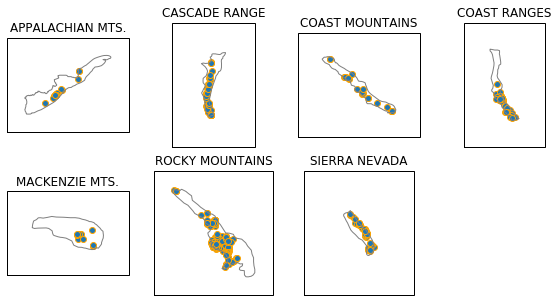

In [26]:
crs = ccrs.PlateCarree()

fig, axs = pl.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': crs})

axs = axs.ravel()

plot_i = 0

for area_i, area in enumerate(areas):
    
    print(area)
    
    if area in da['name'].values:
        ind = da['name'] == area
        #print(da.loc[ind])
        dai = da.loc[ind]

        # select_springs in polygon
        in_polygon = [dai.contains(dsgi).values[0] for dsgi in ds.geometry.values]
        dsi = ds.loc[in_polygon]
        print(len(dsi))
        dr.loc[area, 'n_springs'] = len(dsi)
        
        #world = world.to_crs({'init': 'epsg:3395'})
        area_poly = dai.to_crs("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs").area.values[0]
        
        dr.loc[area, 'geometry'] = da.loc[ind, 'geometry'].values
        
        dr.loc[area, 'area'] = area_poly
        dr.loc[area, 'total_heat_flow_W'] = dsi['Approx Heat Flow (W)'].sum()
        dr.loc[area, 'spring_HF_density_mW_m-2'] = dsi['Approx Heat Flow (W)'].sum() / area_poly * 1000.0
        dr.loc[area, 'total_discharge_m3_s'] = dsi['Discharge (L/s)'].sum() / 1000.0
        dr.loc[area, 'avg_background_heat_flow_mWm-2'] = dsi['Crustal Heat Flow (mW/m2)'].mean()
        #dr.loc[area, 'percentage_of_total_recharge'] = dsi['Precip Area (m2)'].sum() / dr.loc[area, 'area'] * 100

        ##############
        # make figure
        ##############
        ax = axs[plot_i]

        #ax.stock_img()

        ax.set_title(area)

        #dai.plot(ax=ax, color='gray')
        ax.add_geometries(dai['geometry'], facecolor='None', edgecolor='gray', crs=crs)

        #dsi.plot(ax=ax, edgecolor='black', facecolor='None')
        ax.scatter(dsi['Longitude'], dsi['Latitude'], edgecolor='orange', transform=crs)

        buffer = 5.0

        ax.set_xlim(dai.bounds.minx.values[0]-buffer, dai.bounds.maxx.values[0]+buffer)
        ax.set_ylim(dai.bounds.miny.values[0]-buffer, dai.bounds.maxy.values[0]+buffer)
        
        plot_i += 1

axs[-1].remove()
fig.tight_layout()

fig.savefig('fig/distribution_springs_north_america.png', dpi=200)
#########

year = 365.25 * 24 * 3600
dr['percentage_of_total_heat_flow'] = \
    dr['total_heat_flow_W'] / (dr['avg_background_heat_flow_mWm-2'] / 1000.0 * dr['area']) * 100.0
dr['total_discharge_mm_a-1'] = dr['total_discharge_m3_s'] * year / dr['area'] * 1000.0 

In [27]:
dr.head()

,n_springs,area_name,area_name_short,geometry,area,total_heat_flow_W,spring_HF_density_mW_m-2,total_discharge_m3_s,avg_background_heat_flow_mWm-2,percentage_of_total_heat_flow,total_discharge_mm_a-1
Alps,NaN,Alps,AL,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APPALACHIAN MTS.,18,Appalachians,AP,"POLYGON ((-64.97519 48.16923, -65.15880 48.062...",8.525581e+11,3.250012e+07,0.038121,0.506012,57.583333,0.066201,0.018730
CASCADE RANGE,40,Cascades,CA,"POLYGON ((-119.01110 50.86066, -119.10973 50.6...",1.428857e+11,5.388678e+07,0.377132,0.296381,54.955000,0.686256,0.065459
COAST MOUNTAINS,21,Coastal Mts.,CM,"POLYGON ((-134.21074 59.93110, -134.00292 59.6...",2.149131e+11,2.928910e+07,0.136283,0.156313,63.409524,0.214926,0.022953
COAST RANGES,55,Coastal ranges,CR,"POLYGON ((-124.31286 48.26301, -123.78905 48.1...",1.653158e+11,8.359235e+06,0.050565,0.067350,80.318182,0.062956,0.012857


## Add info on the Alps

This uses summary data generated using the analyze_spring_heat_flux_new.ipynb notebook

In [28]:
fnb = 'GIS_data/outline_alps_final.shp'
db = gp.read_file(fnb)
dr.loc['Alps', 'geometry'] = db['geometry'][0]

In [29]:
fna = 'data/summary_thermal_springs_data.csv'
dfa = pd.read_csv(fna)
dfa = dfa.set_index('dataset')

### Add heat flow data Alps

In [30]:
minmaxs1 = ['_min', '', '_max']
minmaxs2 = ['min', 'best', 'max']

for mm1, mm2 in zip(minmaxs1, minmaxs2):
    #dr.loc['Alps', 'percentage_of_total_heat_flow%s' % mm1] = dfa.loc['Alps', 'spring_heat_flux_est_percentage_%s' % mm1]
    dr.loc['Alps', 'spring_HF_density%s_mW_m-2' % mm1] = dfa.loc['Alps', 'total_H_net_%s_mW_m-2' % mm2]

dr.loc['Alps', 'area'] = dfa.loc['Alps', 'area_km2'] * 1e6
dr.loc['Alps', 'n_springs'] = dfa.loc['Alps', 'n_springs']

dr.loc['Alps', 'avg_background_heat_flow_mWm-2'] = 76
    
dr['spring_HF_density_mW_m-2'], dr['area']

(Alps                0.550000
 APPALACHIAN MTS.    0.038121
 CASCADE RANGE       0.377132
 COAST MOUNTAINS     0.136283
 COAST RANGES        0.050565
 MACKENZIE MTS.      0.143606
 ROCKY MOUNTAINS     0.507204
 SIERRA NEVADA       1.497902
 Name: spring_HF_density_mW_m-2, dtype: float64,
 Alps                2.023559e+11
 APPALACHIAN MTS.    8.525581e+11
 CASCADE RANGE       1.428857e+11
 COAST MOUNTAINS     2.149131e+11
 COAST RANGES        1.653158e+11
 MACKENZIE MTS.      3.103657e+11
 ROCKY MOUNTAINS     1.080046e+12
 SIERRA NEVADA       7.026051e+10
 Name: area, dtype: float64)

### Add fluid flow data

In [31]:
dr.loc['Alps', 'total_discharge_mm_a-1'] = \
    dfa.loc['Alps', 'total_spring_flux_km3_yr-1'] * 1e9 / (dfa.loc['Alps', 'area_km2'] * 1e6) * 1e3
dfa.columns.tolist()

dr['total_discharge_mm_a-1']

Alps                0.395343
APPALACHIAN MTS.    0.018730
CASCADE RANGE       0.065459
COAST MOUNTAINS     0.022953
COAST RANGES        0.012857
MACKENZIE MTS.      0.024759
ROCKY MOUNTAINS     0.108303
SIERRA NEVADA       0.174816
Name: total_discharge_mm_a-1, dtype: float64

In [32]:
dr['spring_density'] = (dr['area'] / 1e6) / dr['n_springs']

In [33]:
dr

,n_springs,area_name,area_name_short,geometry,area,total_heat_flow_W,spring_HF_density_mW_m-2,total_discharge_m3_s,avg_background_heat_flow_mWm-2,percentage_of_total_heat_flow,total_discharge_mm_a-1,spring_HF_density_min_mW_m-2,spring_HF_density_max_mW_m-2,spring_density
Alps,394,Alps,AL,"POLYGON ((5.702513796361931 45.47713659882108,...",2.023559e+11,NaN,0.550000,NaN,76.000000,NaN,0.395343,0.42,0.75,513.594
APPALACHIAN MTS.,18,Appalachians,AP,POLYGON ((-64.97518737201227 48.16923497422596...,8.525581e+11,3.250012e+07,0.038121,0.506012,57.583333,0.066201,0.018730,NaN,NaN,47364.3
CASCADE RANGE,40,Cascades,CA,POLYGON ((-119.0110977855413 50.86066315311908...,1.428857e+11,5.388678e+07,0.377132,0.296381,54.955000,0.686256,0.065459,NaN,NaN,3572.14
COAST MOUNTAINS,21,Coastal Mts.,CM,"POLYGON ((-134.210743781635 59.93109772343163,...",2.149131e+11,2.928910e+07,0.136283,0.156313,63.409524,0.214926,0.022953,NaN,NaN,10234
COAST RANGES,55,Coastal ranges,CR,POLYGON ((-124.3128555980413 48.26300690311905...,1.653158e+11,8.359235e+06,0.050565,0.067350,80.318182,0.062956,0.012857,NaN,NaN,3005.74
MACKENZIE MTS.,10,Mackenzie Mts.,MK,POLYGON ((-131.1191300121038 65.78961823124413...,3.103657e+11,4.457039e+07,0.143606,0.243504,77.430000,0.185466,0.024759,NaN,NaN,31036.6
ROCKY MOUNTAINS,220,Rocky Mts,RM,"POLYGON ((-124.565235969135 59.71057770390036,...",1.080046e+12,5.478040e+08,0.507204,3.706632,114.535455,0.442836,0.108303,NaN,NaN,4909.3
SIERRA NEVADA,40,Sierra Nevada,SN,"POLYGON ((-118.1984146800725 35.1114566101503,...",7.026051e+10,1.052434e+08,1.497902,0.389213,73.915000,2.026520,0.174816,NaN,NaN,1756.51


## Show results in a figure

## Some figure parameters:

In [43]:
ms=10
ybuffer = 0.025

# variables on y-axis:
yvar = 'spring_HF_density_mW_m-2'
ylabel = r'Net HF springs (mW m$^{-2}$)'
yvar2 = 'total_discharge_mm_a-1'
ylabel2 = r'Spring discharge ($mm\;a^{-1}$)'

# y-axis extent
ylim1 = [0, 2.0]
ylim2 = [0, 0.6]

# map projection
crs = ccrs.PlateCarree()

# marker size
s = 100

In [49]:
dr = dr.sort_values(by=yvar2, ascending=False)
dr

,n_springs,area_name,area_name_short,geometry,area,total_heat_flow_W,spring_HF_density_mW_m-2,total_discharge_m3_s,avg_background_heat_flow_mWm-2,percentage_of_total_heat_flow,total_discharge_mm_a-1,spring_HF_density_min_mW_m-2,spring_HF_density_max_mW_m-2,spring_density
Alps,394,Alps,AL,"POLYGON ((5.70251 45.47714, 5.84122 45.60113, ...",2.023559e+11,NaN,0.550000,NaN,76.000000,NaN,0.395343,0.42,0.75,513.594
SIERRA NEVADA,40,Sierra Nevada,SN,"POLYGON ((-118.19841 35.11146, -118.59527 34.8...",7.026051e+10,1.052434e+08,1.497902,0.389213,73.915000,2.026520,0.174816,NaN,NaN,1756.51
ROCKY MOUNTAINS,220,Rocky Mts,RM,"POLYGON ((-124.56524 59.71058, -123.32653 59.0...",1.080046e+12,5.478040e+08,0.507204,3.706632,114.535455,0.442836,0.108303,NaN,NaN,4909.3
CASCADE RANGE,40,Cascades,CA,"POLYGON ((-119.01110 50.86066, -119.10973 50.6...",1.428857e+11,5.388678e+07,0.377132,0.296381,54.955000,0.686256,0.065459,NaN,NaN,3572.14
MACKENZIE MTS.,10,Mackenzie Mts.,MK,"POLYGON ((-131.11913 65.78962, -129.73424 65.6...",3.103657e+11,4.457039e+07,0.143606,0.243504,77.430000,0.185466,0.024759,NaN,NaN,31036.6
COAST MOUNTAINS,21,Coastal Mts.,CM,"POLYGON ((-134.21074 59.93110, -134.00292 59.6...",2.149131e+11,2.928910e+07,0.136283,0.156313,63.409524,0.214926,0.022953,NaN,NaN,10234
APPALACHIAN MTS.,18,Appalachians,AP,"POLYGON ((-64.97519 48.16923, -65.15880 48.062...",8.525581e+11,3.250012e+07,0.038121,0.506012,57.583333,0.066201,0.018730,NaN,NaN,47364.3
COAST RANGES,55,Coastal ranges,CR,"POLYGON ((-124.31286 48.26301, -123.78905 48.1...",1.653158e+11,8.359235e+06,0.050565,0.067350,80.318182,0.062956,0.012857,NaN,NaN,3005.74


## Construct figure:

Alps AL
APPALACHIAN MTS. AP
CASCADE RANGE CA
COAST MOUNTAINS CM
COAST RANGES CR
MACKENZIE MTS. MK
ROCKY MOUNTAINS RM
SIERRA NEVADA SN


/Users/elcopone/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


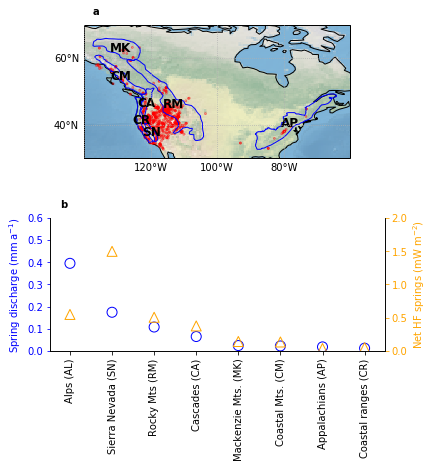

In [56]:
fig = pl.figure(figsize=(6, 6))

axs = [fig.add_subplot(2, 1, 1, projection=crs)]

axs += [fig.add_subplot(2, 1, 2)]

####### map thermal springs USA

axs[0].stock_img()

# show areas
for area_i, area, short_label in zip(itertools.count(), areas, area_labels_short):
    
    print(area, short_label)
    
    ind = da['name'] == area
    #print(da.loc[ind])
    dai = da.loc[ind]
    
    if area in da['name'].values:
        
        #dai.plot(ax=ax, color='gray')
        axs[0].add_geometries(dai['geometry'], facecolor='none', edgecolor='blue', crs=crs, zorder=100)
        
        d = dai['geometry'].centroid.values[0]
        c = d.coords[:][0]
        axs[0].text(c[0], c[1], short_label, fontsize='large',
                    va='center', ha='center', transform=crs, weight='bold', zorder=102)

        #dsi.plot(ax=ax, edgecolor='black', facecolor='None')

# show springs
axs[0].scatter(ds['Longitude'], ds['Latitude'], edgecolor='red', facecolor='none', 
               s=3, alpha=0.5,
               transform=crs, zorder=99)

axs[0].set_xlim(-140, -60)
axs[0].set_ylim(30, 70)

axs[0].coastlines()
        
gl = axs[0].gridlines(xlocs=[-140, -120, -100, -80, -60], ylocs=[20, 40, 60, 80], 
                      crs=crs, zorder=2001, linestyle=':', 
                      draw_labels=True)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
##############

axl = axs[-1]
axr = axs[-1].twinx()

axl.scatter(dr['area_name_short'], dr[yvar2], facecolor='none', edgecolor='blue', s=s)

#ax.set_xlabel()
axl.set_ylabel(ylabel2)

axr.scatter(dr['area_name_short'], dr[yvar], facecolor='none', marker='^', edgecolor='orange', s=s)
    
axr.set_ylabel(ylabel)

xt = axl.get_xticks()

n = dr['area_name']
ns = dr['area_name_short']

new_labels = [ni + ' (%s)' % nsi for ni, nsi in zip(n, ns)]
xt[:] = new_labels[:]
axl.set_xticklabels(xt, rotation=90)

for i, axi in enumerate(axs):
    axi.spines['top'].set_visible(False)
    #axi.spines['right'].set_visible(False)
    axi.text(0.03, 1.06, string.ascii_lowercase[i], 
        weight='bold', transform=axi.transAxes, ha='left', va='bottom')

axl.yaxis.label.set_color('blue')
axl.tick_params(axis='y', colors='blue')
axl.set_ylim(ylim2)
    
axr.spines['top'].set_visible(False)
axr.yaxis.label.set_color('orange')
axr.tick_params(axis='y', colors='orange')
axr.set_ylim(ylim1)

fig.subplots_adjust(hspace=0.45, wspace=0.45) 
fig.tight_layout()
    
fig.savefig('fig/comparison_orogens_simple.pdf')
fig.savefig('fig/comparison_orogens_simple.png')

## Save data:

In [1]:
fno = 'data/comparison_heat_flux_orogens.csv'
dr.to_csv(fno, index_label='area')

NameError: name 'dr' is not defined